In [53]:
import nilearn.image as ni
import nibabel as nb
from nilearn.plotting import plot_anat, plot_prob_atlas, show
import SimpleITK as sitk
from utils import pad_nifti_image, multires_registration
from aligner import Aligner
from warp_utils import apply_warp
import numpy as np
from monai.transforms import LoadImage, EnsureChannelFirst

# %matplotlib notebook
# import gui

/home/ajoshi/anaconda3/lib/python3.10/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: The following kwargs were not used by contour: 'color'
  im = getattr(ax, type)(data_2d.copy(),


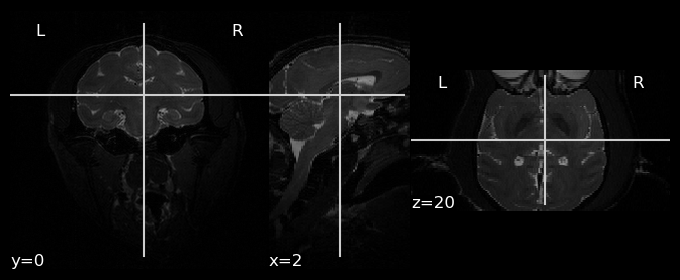

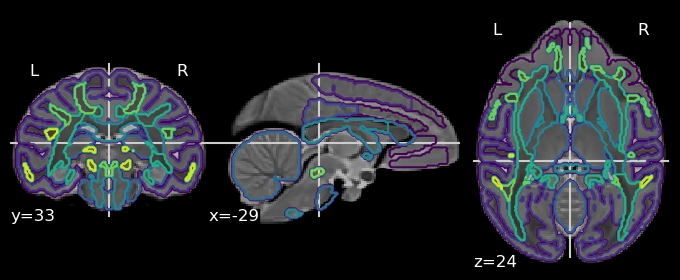

In [61]:
sub_bse_t2_orig = "/deneb_disk/macaque_atlas_data/test_data/MAC10.nii.gz"
sub_bse_t2 = "/deneb_disk/macaque_atlas_data/test_data/MAC10_pad.nii.gz"
sub_mask_t2_orig = "/deneb_disk/macaque_atlas_data/test_data/MAC10.mask.nii.gz"
sub_mask_t2 = "/deneb_disk/macaque_atlas_data/test_data/MAC10_pad.mask.nii.gz"

atlas_bse_t2 = "/deneb_disk/macaque_atlas_data/macaque_atlas/ONPRC18_atlas_v1/ONPRC18_Templates/ONPRC18_T2W_brain.nii.gz"
atlas_labels = "/deneb_disk/macaque_atlas_data/macaque_atlas/ONPRC18_atlas_v1/ONPRC18_Labelmaps/ONPRC18_GrayMatterWhiteMatterLabelmap.nii.gz"

centered_atlas = "/deneb_disk/macaque_atlas_data/test_data/atlas.nii.gz"
centered_atlas_labels = "/deneb_disk/macaque_atlas_data/test_data/atlas.label.nii.gz"

lin_reg_map_file = "/deneb_disk/macaque_atlas_data/test_data/lin_ddf.nii.gz"

centered_atlas_linreg = "/deneb_disk/macaque_atlas_data/test_data/atlas_lin.nii.gz"
centered_atlas_linreg_labels = "/deneb_disk/macaque_atlas_data/test_data/atlas_lin.label.nii.gz"

PAD = 10

plot_anat(sub_bse_t2_orig)
d = plot_anat(atlas_bse_t2)
d.add_contours(atlas_labels, color='r')

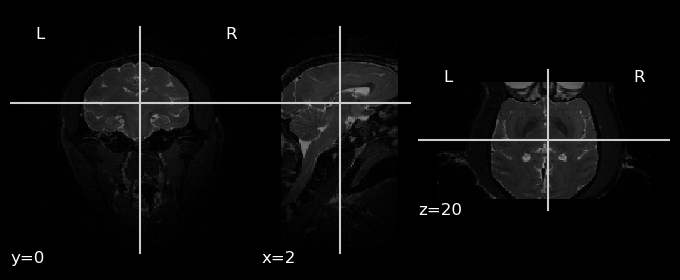

In [55]:
pad_nifti_image(sub_bse_t2_orig, sub_bse_t2, PAD)
pad_nifti_image(sub_mask_t2_orig, sub_mask_t2, PAD)
plot_anat(sub_bse_t2)

Final metric value: -0.42996935296891936
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 64.


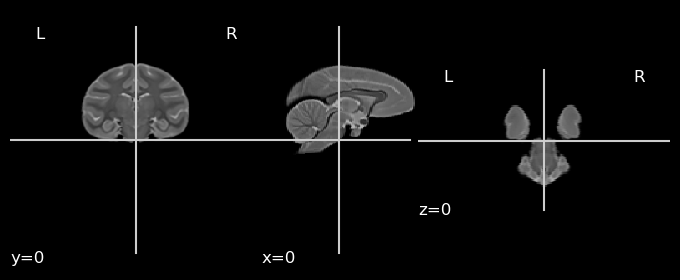

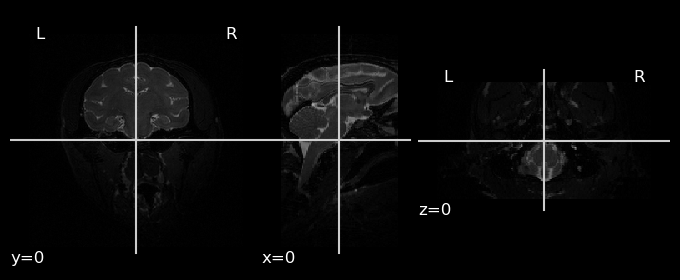

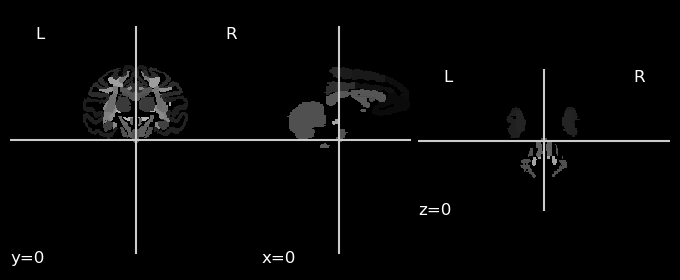

"\nreader = sitk.ImageSeriesReader()\nfixed_image = sitk.ReadImage(sub_bse_t2, sitk.sitkFloat32)\nmoving_image = sitk.ReadImage(atlas_bse_t2, sitk.sitkFloat32)\n\n\n\ngui.MultiImageDisplay(image_list = [fixed_image, moving_image],                   \n                      title_list = ['fixed image', 'moving image']);\n"

In [56]:
fixed_image = sitk.ReadImage(sub_bse_t2, sitk.sitkFloat32)
moving_image = sitk.ReadImage(atlas_bse_t2, sitk.sitkFloat32)
initial_transform = sitk.CenteredTransformInitializer(
    fixed_image,
    moving_image,
    sitk.Euler3DTransform(),
    sitk.CenteredTransformInitializerFilter.GEOMETRY,
)

final_transform, _ = multires_registration(fixed_image, moving_image, initial_transform)

moved_image = sitk.Resample(moving_image, fixed_image, final_transform)

sitk.WriteImage(moved_image, centered_atlas)

moving_image = sitk.ReadImage(atlas_labels,sitk.sitkUInt16)
moved_image = sitk.Resample(moving_image, fixed_image, transform=final_transform,interpolator=sitk.sitkNearestNeighbor)
sitk.WriteImage(moved_image, centered_atlas_labels)


plot_anat(centered_atlas, cut_coords=(0, 0, 0))
plot_anat(sub_bse_t2, cut_coords=(0, 0, 0))
plot_anat(centered_atlas_labels,cut_coords=(0,0,0))

show()


"""
reader = sitk.ImageSeriesReader()
fixed_image = sitk.ReadImage(sub_bse_t2, sitk.sitkFloat32)
moving_image = sitk.ReadImage(atlas_bse_t2, sitk.sitkFloat32)



gui.MultiImageDisplay(image_list = [fixed_image, moving_image],                   
                      title_list = ['fixed image', 'moving image']);
"""

/home/ajoshi/anaconda3/lib/python3.10/site-packages/monai/networks/blocks/warp.py:66: UserWarning: monai.networks.blocks.Warp: Using PyTorch native grid_sample.
  warnings.warn("monai.networks.blocks.Warp: Using PyTorch native grid_sample.")


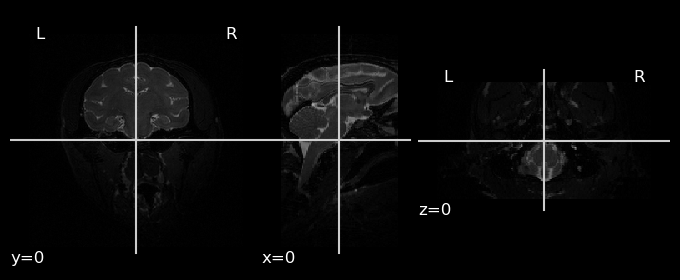

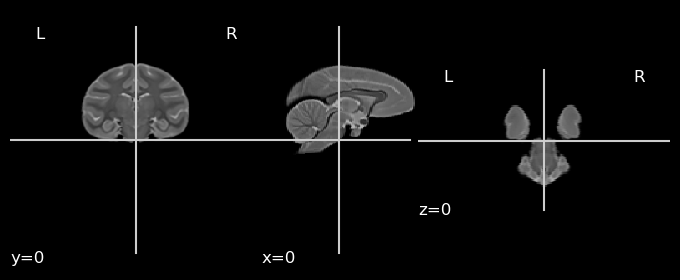

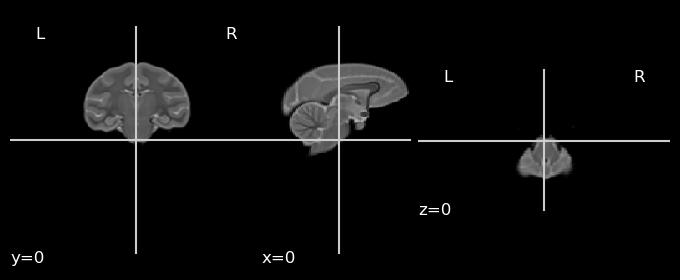

In [57]:
aligner=Aligner()
aligner.affine_reg(fixed_file=sub_bse_t2, moving_file=centered_atlas, output_file=centered_atlas_linreg, ddf_file=lin_reg_map_file)

plot_anat(sub_bse_t2,cut_coords=(0,0,0))
plot_anat(centered_atlas,cut_coords=(0,0,0))
plot_anat(centered_atlas_linreg,cut_coords=(0,0,0))




torch.Size([3, 302, 106, 302])
torch.Size([1, 302, 106, 302])


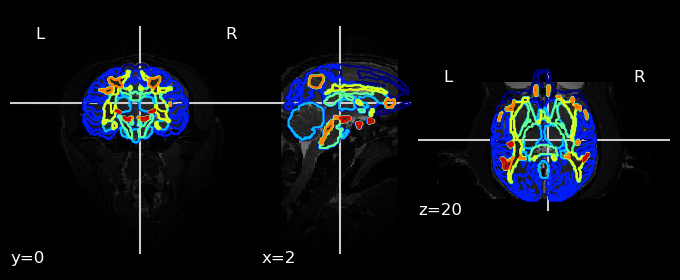

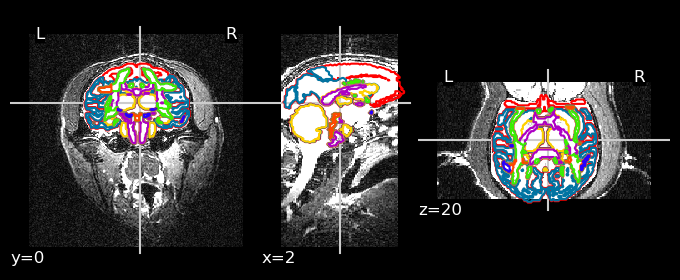

In [ ]:

#disp_field=nb.load(lin_reg_map_file).get_fdata()

disp_field, meta = LoadImage()(lin_reg_map_file)
disp_field = EnsureChannelFirst()(disp_field)
print(disp_field.shape)

at1, meta = LoadImage()(centered_atlas_labels)
at_lab = EnsureChannelFirst()(at1)

#disp_field=np.transpose(disp_field,axes=(3,0,1,2))
#disp_field=disp_field[None,]
print(at_lab.shape)

#at1 = nb.load(centered_atlas_labels)
#at_lab=at1.get_fdata()
#at_lab.shape
#at_lab = at_lab[None,None]
warped_lab=apply_warp(disp_field[None,], at_lab[None,], at_lab[None,], interp_mode='nearest')
nb.save(nb.Nifti1Image(warped_lab[0, 0].detach().cpu().numpy(), at_lab.affine), centered_atlas_linreg_labels)

#plot_anat(centered_atlas_linreg_labels,cut_coords=(0,0,0))


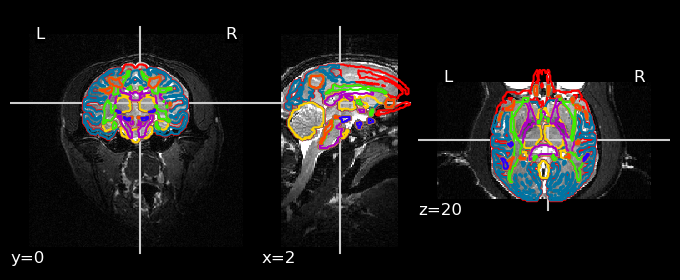

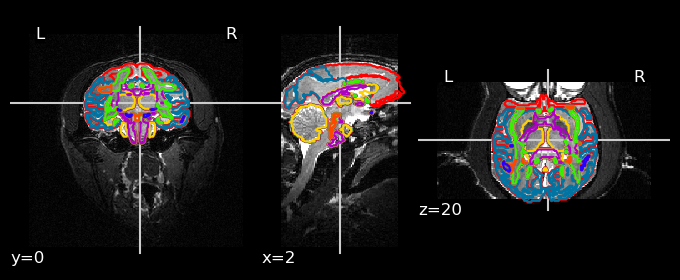

In [72]:

d = plot_anat(sub_bse_t2,vmax=1400)
d.add_contours(centered_atlas_labels, cmap ='prism')
d = plot_anat(sub_bse_t2,vmax=1400)
d.add_contours(centered_atlas_linreg_labels, cmap ='prism')